# 4. LSTM

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Pseudo-Lab/Tutorial-Book-en/blob/master/book/chapters/en/time-series/Ch4-LSTM.ipynb)

In the previous chapter, we transformed time series data shared by Johns Hopkins University into supervised learning data. In this chapter, we will build a model to predict daily COVID-19 cases in South Korea using LSTM (Long Short-Term Memory).

In chapter 4.1 and 4.2, we will divide the dataset into training, test, and validation sets after loading the cumulative COVID-19 cases for South Korea. In chapter 4.3, we will define the LSTM model, and then in chapter 4.4, we will train the model. Lastly, we will examine the predicted COVID-19 cases.

Firstly, import the basic modules we will need to use.

Through `%matplotlib inline`, visualizations can appear in the notebook, while `%config InlineBackend.figure_format='retina'` helps improve the graphics resolution of the visualizations.


In [10]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## 4.1 Download Datasets


We will load the datasets containing the cumulative COVID-19 cases in South Korea for modeling practice. We will use the code from chapter 2.1. 

In [2]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data COVIDTimeSeries
!unzip -q COVIDTimeSeries.zip

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 6), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (24/24), done.
COVIDTimeSeries.zip is done!


## 4.2 Data Pre-Processing

After transforming the time series data into supervised learning data, using the code we used in chapter 3, we will divide the data into training, validation, and test sets. After that, we will perform data scaling based on the statistics of the training data. 

In [3]:
#Load the cumulative COVID-19 cases for South Korea.
confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed[confirmed['Country/Region']=='Korea, South']
korea = confirmed[confirmed['Country/Region']=='Korea, South'].iloc[:,4:].T
korea.index = pd.to_datetime(korea.index)
daily_cases = korea.diff().fillna(korea.iloc[0]).astype('int')


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length)]
        y = data.iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Data transformation for supervised learning data.
seq_length = 5
X, y = create_sequences(daily_cases, seq_length)

# Dividing the dataset into traning, validation, and test sets.
train_size = int(327 * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+33], y[train_size:train_size+33]
X_test, y_test = X[train_size+33:], y[train_size+33:]

MIN = X_train.min()
MAX = X_train.max()

def MinMaxScale(array, min, max):

    return (array - min) / (max - min)

#MinMax scaling.
X_train = MinMaxScale(X_train, MIN, MAX)
y_train = MinMaxScale(y_train, MIN, MAX)
X_val = MinMaxScale(X_val, MIN, MAX)
y_val = MinMaxScale(y_val, MIN, MAX)
X_test = MinMaxScale(X_test, MIN, MAX)
y_test = MinMaxScale(y_test, MIN, MAX)

#Tensor transformation.
def make_Tensor(array):
    return torch.from_numpy(array).float()

X_train = make_Tensor(X_train)
y_train = make_Tensor(y_train)
X_val = make_Tensor(X_val)
y_val = make_Tensor(y_val)
X_test = make_Tensor(X_test)
y_test = make_Tensor(y_test)

In [4]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

torch.Size([261, 5, 1]) torch.Size([33, 5, 1]) torch.Size([33, 5, 1])
torch.Size([261, 1]) torch.Size([33, 1]) torch.Size([33, 1])


## 4.3 Defining the LSTM Model

We will build the LSTM model. `CovidPredictor` consists of basic attributes, constructor for layer initialization, the `reset_hidden_state` function for resetting weights, and the `forward` function for prediction.

In [5]:
class CovidPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers):
        super(CovidPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )
    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

## 4.4 Training

We will define the `train_model` function in order to train `CovidPredictor`, which we already defined in chapter 4.3. The inputs are from the training and validation sets; `num_epochs` indicates the number of epoch times. `verbose` here indicates how often each `epoch` is printed. `patience` is used to stop training if validation loss ceases to decrease after `patience` number of epochs. In PyTorch, `hidden_state` is preserved throughout the training, so `hidden_state` needs to be reset every sequence in order not to be affected from the previous `hidden_state`.


In [6]:
def train_model(model, train_data, train_labels, val_data=None, val_labels=None, num_epochs=100, verbose = 10, patience = 10):
    loss_fn = torch.nn.L1Loss() #
    optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
    train_hist = []
    val_hist = []
    for t in range(num_epochs):

        epoch_loss = 0

        for idx, seq in enumerate(train_data): 

            model.reset_hidden_state() # reset hidden state per seq

            # train loss
            seq = torch.unsqueeze(seq, 0)
            y_pred = model(seq)
            loss = loss_fn(y_pred[0].float(), train_labels[idx]) # loss about 1 step

            # update weights
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        train_hist.append(epoch_loss / len(train_data))

        if val_data is not None:

            with torch.no_grad():

                val_loss = 0

                for val_idx, val_seq in enumerate(val_data):

                    model.reset_hidden_state() # reset hidden state per seq

                    val_seq = torch.unsqueeze(val_seq, 0)
                    y_val_pred = model(val_seq)
                    val_step_loss = loss_fn(y_val_pred[0].float(), val_labels[val_idx])

                    val_loss += val_step_loss
                
            val_hist.append(val_loss / len(val_data)) # append in val hist

            ## print loss every verbose
            if t % verbose == 0:
                print(f'Epoch {t} train loss: {epoch_loss / len(train_data)} val loss: {val_loss / len(val_data)}')

            ## check early stopping every patience
            if (t % patience == 0) & (t != 0):
                
                ## early stop if loss is on
                if val_hist[t - patience] < val_hist[t] :

                    print('\n Early Stopping')

                    break

        elif t % verbose == 0:
            print(f'Epoch {t} train loss: {epoch_loss / len(train_data)}')

            
    return model, train_hist, val_hist

In [7]:
model = CovidPredictor(
    n_features=1,
    n_hidden=4,
    seq_len=seq_length,
    n_layers=1
)
model, train_hist, val_hist = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    num_epochs=100,
    verbose=10,
    patience=50
)

Epoch 0 train loss: 0.0846735675929835 val loss: 0.047220394015312195
Epoch 10 train loss: 0.03268902644807637 val loss: 0.03414301574230194
Epoch 20 train loss: 0.03255926527910762 val loss: 0.03243739902973175
Epoch 30 train loss: 0.032682761279652 val loss: 0.033064160495996475
Epoch 40 train loss: 0.0325928641549201 val loss: 0.032514143735170364
Epoch 50 train loss: 0.032316437919741904 val loss: 0.033000096678733826
Epoch 60 train loss: 0.03259847856704788 val loss: 0.03266565129160881
Epoch 70 train loss: 0.03220883647418827 val loss: 0.032897673547267914
Epoch 80 train loss: 0.03264666339685834 val loss: 0.032588861882686615
Epoch 90 train loss: 0.032349443449406844 val loss: 0.03221791982650757


Let's visualize the loss values saved in `train_hist` and `val_hist`.

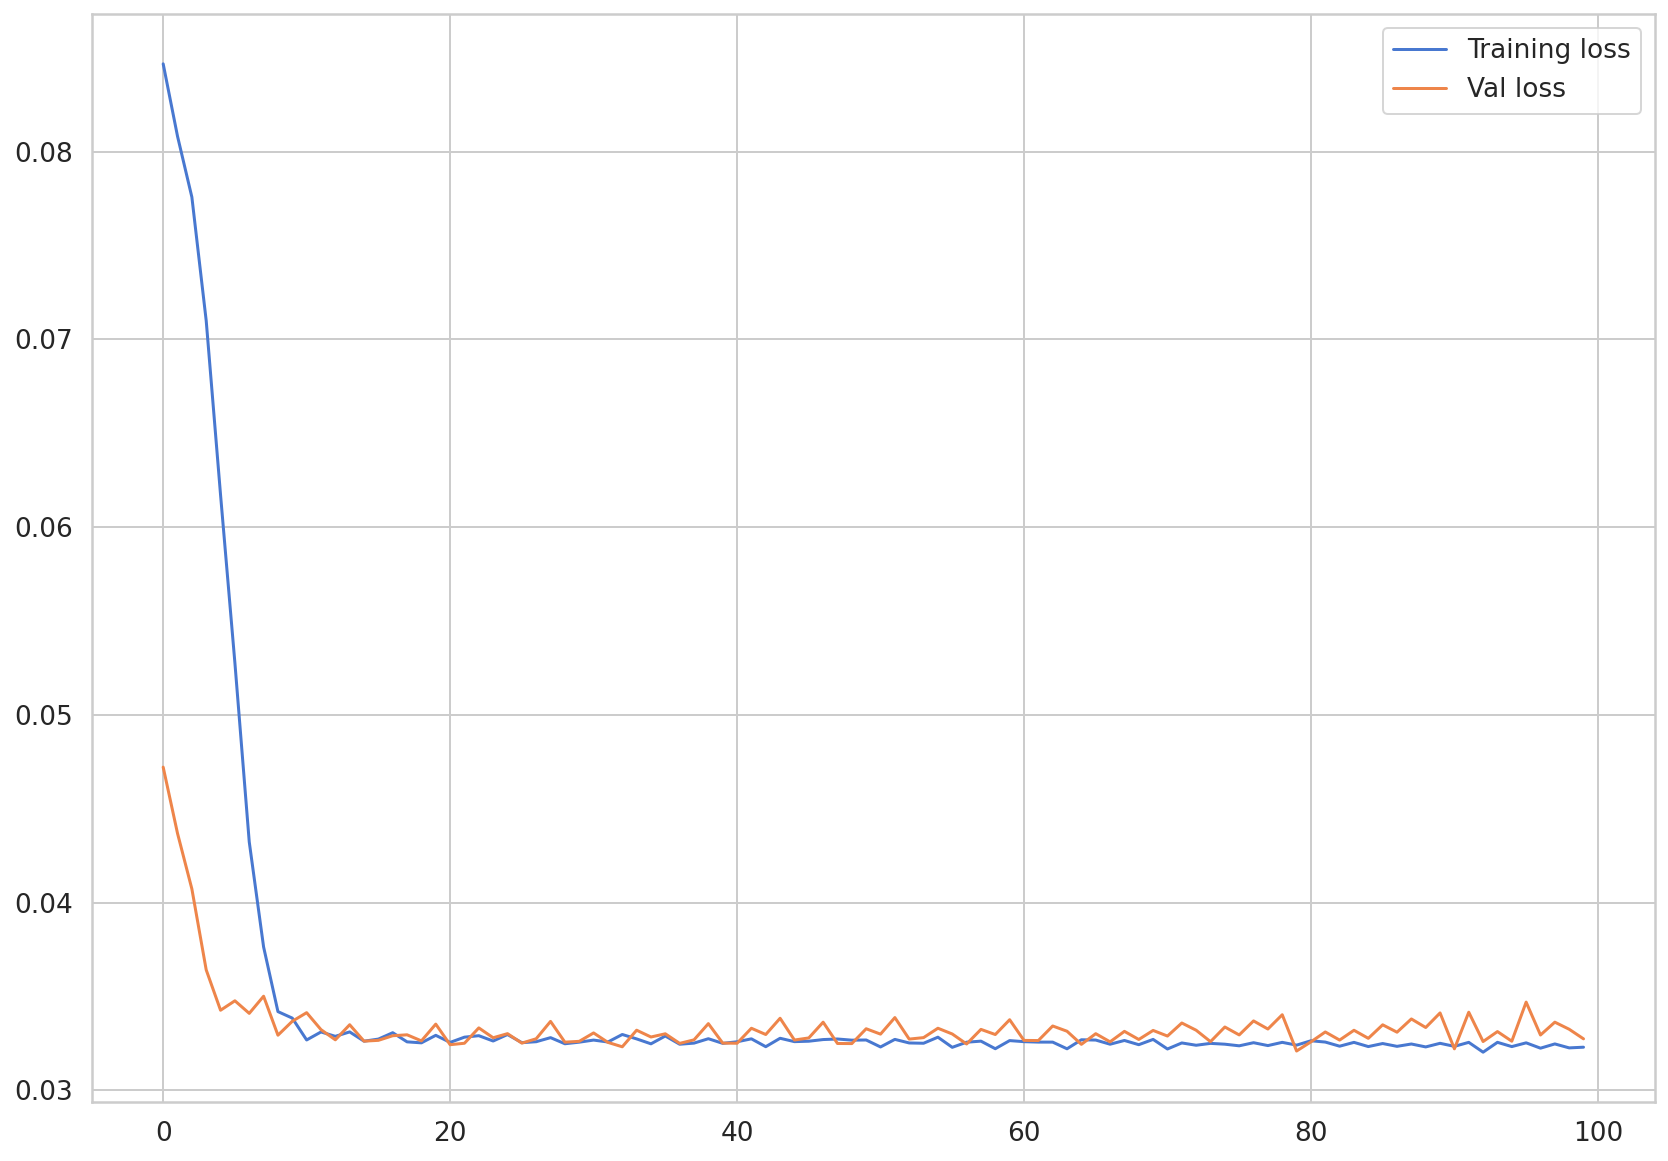

In [11]:
plt.plot(train_hist, label="Training loss")
plt.plot(val_hist, label="Val loss")
plt.legend()

## 4.5 Prediction

In chapter 4.5, we will make a prediction about new input data using the model we built. The built model predicts new COVID-19 cases using the data range $t-5$ to $t-1$. Similarly, if new observed data in a range of $t-5$ to $t-1$ were input, it would be possible to predict COVID-19 cases in time $t$. We call this a `One-Step` prediction. This is a method to predict only one step ahead based on previous data.

On the other hand, a `Multi-Step` prediction predicts several steps ahead based on previous data. A `Multi-Step` prediction can be achieved with two methods: one is to exploit the `One-Step` model we built earlier, and the other is to utilize a <code>seq2seq</code> model architecture.

The first method is to predict value at $t+1$ using the predicted value at time $t$ from the `One-Step` prediction model, which is annotated as $\hat{t}$. This is achieved by predicting value at time $t+1$ using values of $t-4$, $t-3$, $t-2$, $t-1$, and $\hat{t}$. With this method, it is possible to predict values using previously predicted values as a model input, but this causes a loss in prediction performance in the long run due to the cumulative error of predicted values.

The other method is to perform a prediction using `seq2seq` model architecture. This method predicts future values by setting the length of the `decoder` same as the length of the future period we want to predict. There is the advantage of being able to use additional information through a `decoder` network when calculating prediction values, but the length of the future period must be fixed.

In this chapter, we will examine a `Multi-Step` prediction through code, which iteratively uses a `One-Step` prediction model. 

### 4.5.1 One-Step Prediction

Firstly, we will view the performance of the model we built earlier by performing a `One-Step` prediction. We will predict on the test dataset we built. Whenever new sequence values are input for a prediction, we need to reset `hidden_state` to avoid reflecting the previous `hidden_state` calculated from the previous sequence. Using the `torch.unsqueeze` function, we need to extend the dimensions of the input data to a three-dimensional shape that the model expects. In addition, we will extract only the scalar value from the `y_test_pred` to be added to the <code>preds</code> list.

In [19]:
pred_dataset = X_test

with torch.no_grad():
    preds = []
    for _ in range(len(pred_dataset)):
        model.reset_hidden_state()
        y_test_pred = model(torch.unsqueeze(pred_dataset[_], 0))
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)

We will compare the predicted values that the model predicted to the true values. True values are saved in `y_test`, where the data has already been through data scaling. We will utilize the formula below in order to transform the values back into the original scale. The formula below was tweaked based on the formula used for MinMax scaling before. 

> $x = x_{scaled} * (x_{max} - x_{min}) + x_{min}$

In the data, $x_{min}$ was 0. Therefore, all we need is to multiply $x_{max}$ to the scaled value to restore it into original scale. 

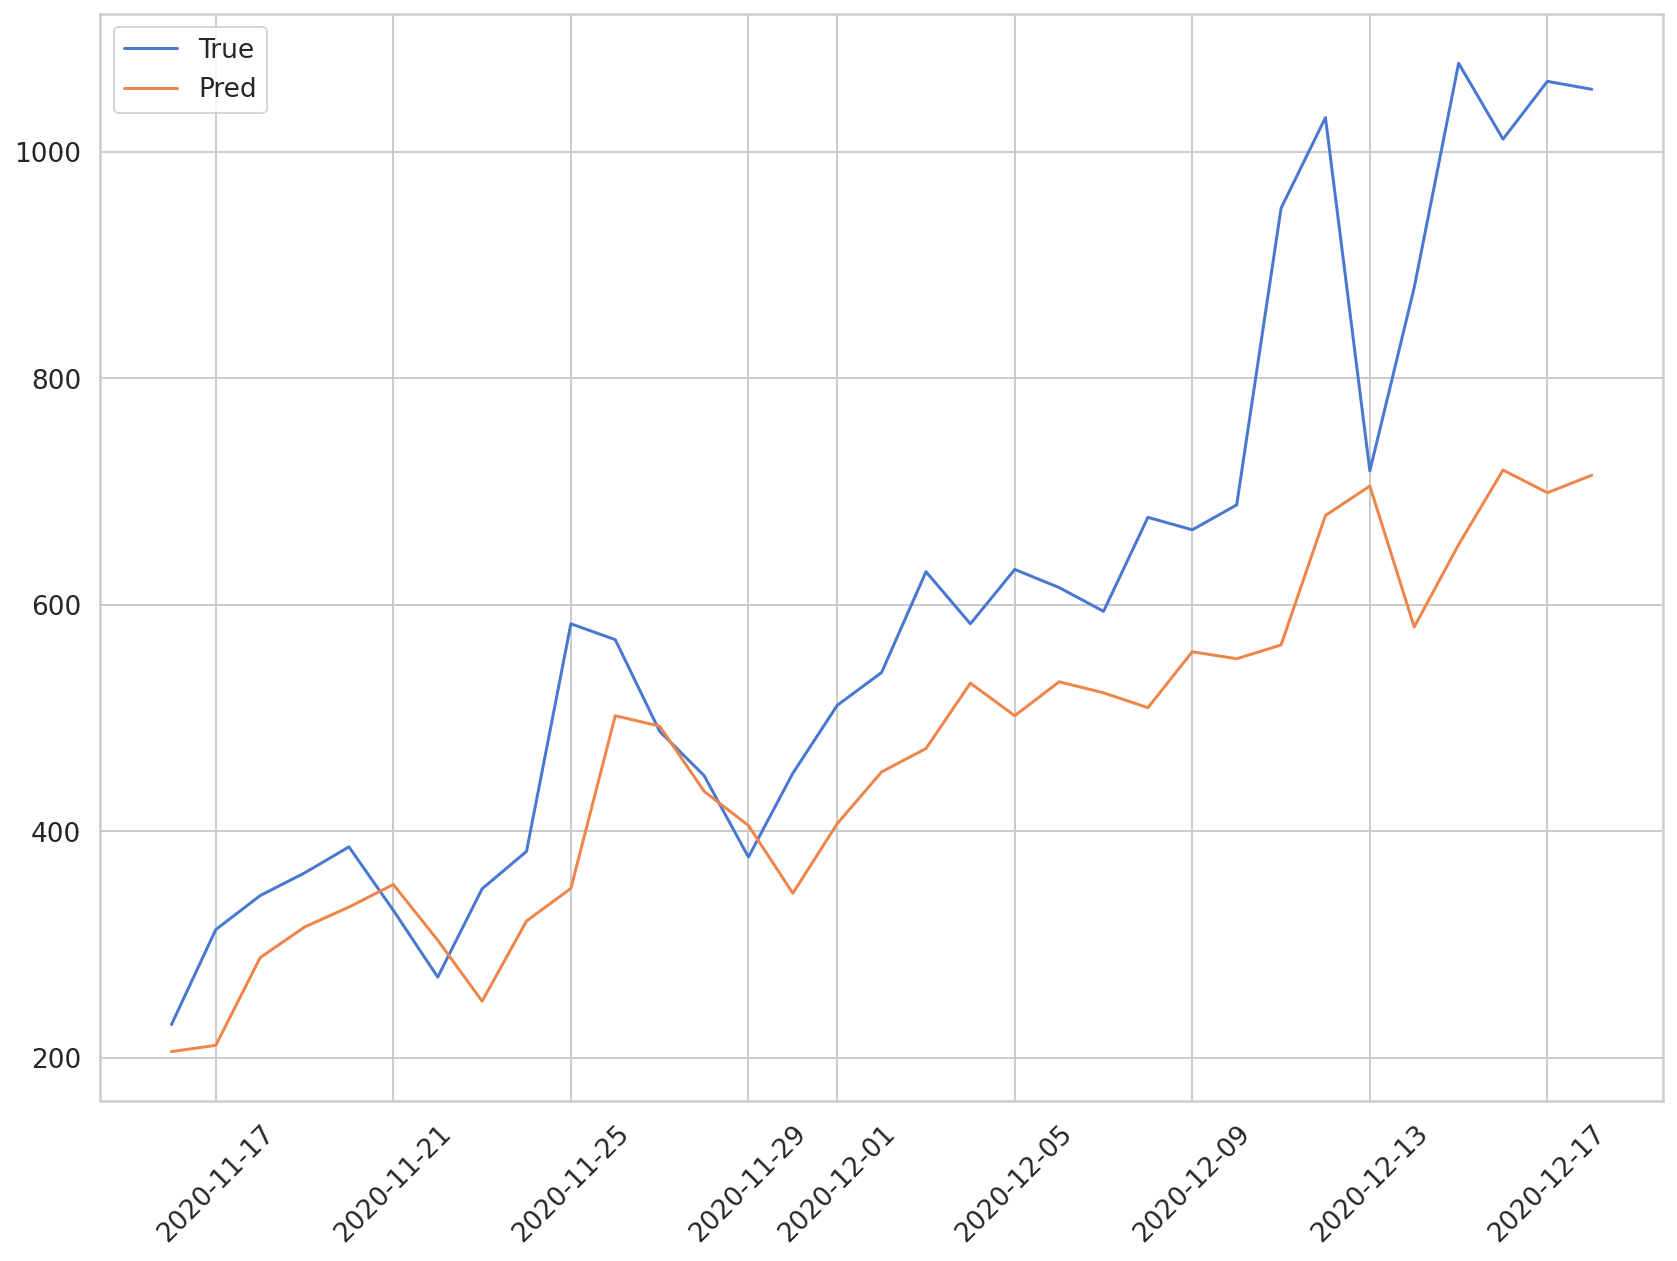

In [20]:
plt.plot(daily_cases.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(daily_cases.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.legend()

The blue line shows the true values, and the orange line reveals the predicted values. Although the model predicts the rising trend of new COVID-19 cases, it does not predict the sharp rise in cases towards the middle of December.

We will calculate the MAE in order to find the mean absolute error of the predicted values. 

In [23]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))

In [24]:
MAE(np.array(y_test)*MAX, np.array(preds)*MAX)

247.3132225984521

We can see that the predicted values show an average difference of around 250 cases compared to the true values. It would be more precise if we used population movement and statistics data, and so on, in addition to the data on previous COVID-19 cases. 

### 4.5.2 Multi-Step Prediction

We will perform a `Multi-Step` prediction, iteratively using the `One-Step` prediction model. We will predict future values by including the predicted value generated through the first sample of the test data into the input sequence, and then repeating the predictions by including the new predicted values into the input sequence. 

In [25]:
with torch.no_grad():
    test_seq = X_test[:1] # The first test set, three-dimension.
    preds = []
    for _ in range(len(X_test)):
        model.reset_hidden_state()
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq, [pred]) # Append in sequence. 
        new_seq = new_seq[1:] # Add additional values to make seq_length 5.
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

As mentioned above, as the prediction period gets longer, the accuracy of this method begins to wane. Let's visualize the comparison between the predicted and true values below.

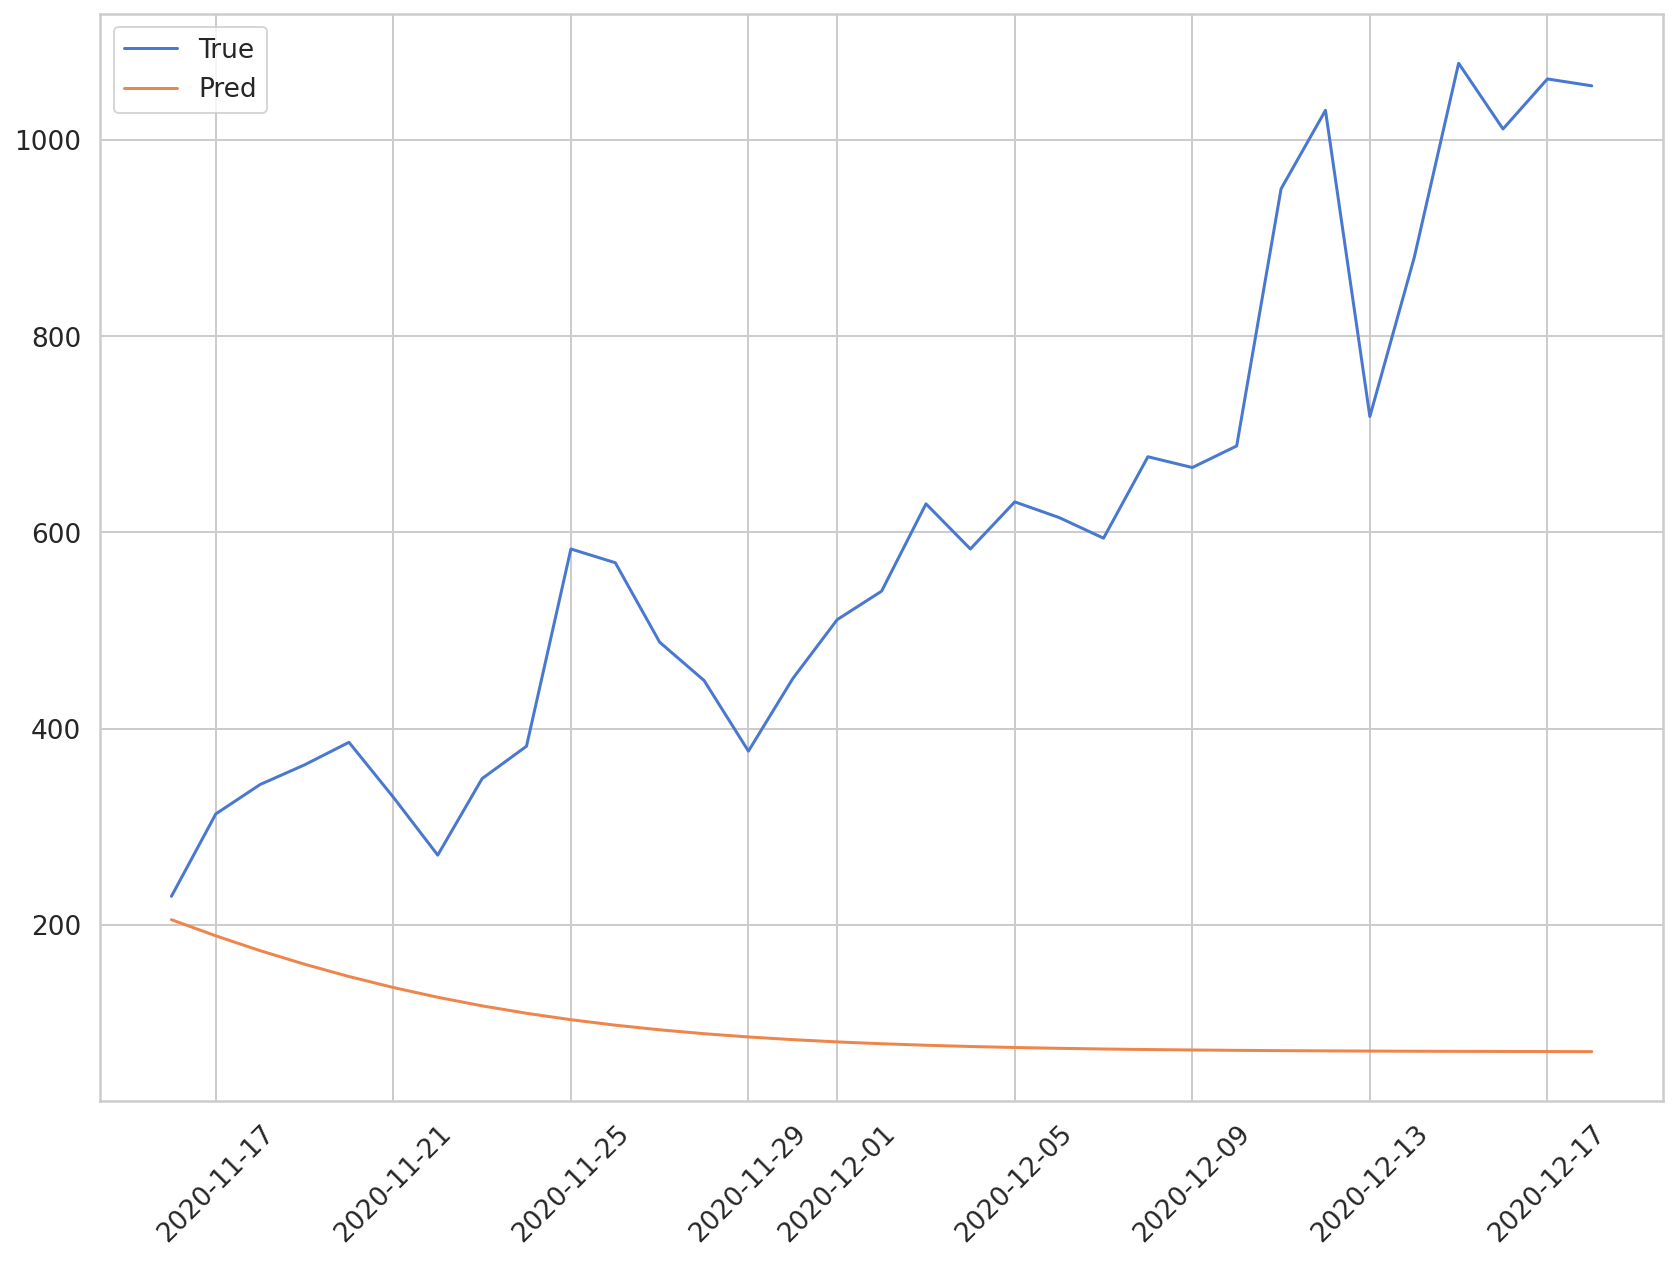

In [28]:
plt.plot(daily_cases.index[-len(y_test):], np.array(y_test) * MAX, label='True')
plt.plot(daily_cases.index[-len(preds):], np.array(preds) * MAX, label='Pred')
plt.xticks(rotation=45)
plt.legend()

In this chapter, we practiced building an LSTM model, using COVID-19 cases. In the next chapter, we will learn how to apply CNN-LSTM model to times series data. 